In [5]:
# Loading the Dataset and Necessary Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression as SklearnLR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression

# Load dataset
file_path = "/content/drive/MyDrive/Food_Delivery_Times.csv"  # Update this path
df = pd.read_csv(file_path)

# Display first few rows and dataset info
print(df.head())
print(df.info())
print("Dataset Columns:", df.columns.tolist())


   Order_ID  Distance_km Weather Traffic_Level Time_of_Day Vehicle_Type  \
0       522         7.93   Windy           Low   Afternoon      Scooter   
1       738        16.42   Clear        Medium     Evening         Bike   
2       741         9.52   Foggy           Low       Night      Scooter   
3       661         7.44   Rainy        Medium   Afternoon      Scooter   
4       412        19.03   Clear           Low     Morning         Bike   

   Preparation_Time_min  Courier_Experience_yrs  Delivery_Time_min  
0                    12                     1.0                 43  
1                    20                     2.0                 84  
2                    28                     1.0                 59  
3                     5                     1.0                 37  
4                    16                     5.0                 68  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  N

In [6]:
# Data cleaning

# Check for missing values and duplicates
print(df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())

# Drop duplicate rows
df = df.drop_duplicates()

# Handle missing values
num_cols = df.select_dtypes(include=["number"]).columns
imputer = SimpleImputer(strategy="mean")
df[num_cols] = imputer.fit_transform(df[num_cols])

cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Convert data types
df["Delivery_Time_min"] = pd.to_numeric(df["Delivery_Time_min"], errors="coerce")
df["Time_of_Day"] = pd.to_datetime(df["Time_of_Day"], errors="coerce")

# Remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in num_cols:
    df = remove_outliers_iqr(df, col)

# Standardize numerical features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Encode categorical features
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

# Save cleaned dataset
df.to_csv("cleaned_food_delivery_times.csv", index=False)
print("Data cleaning complete. File saved!")


Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64
Duplicate rows: 0
Data cleaning complete. File saved!


<ipython-input-6-cac35c1026ff>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
<ipython-input-6-cac35c1026ff>:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Time_of_Day"] = pd.to_datetime(df["Time_of_Day"], errors="coerce")


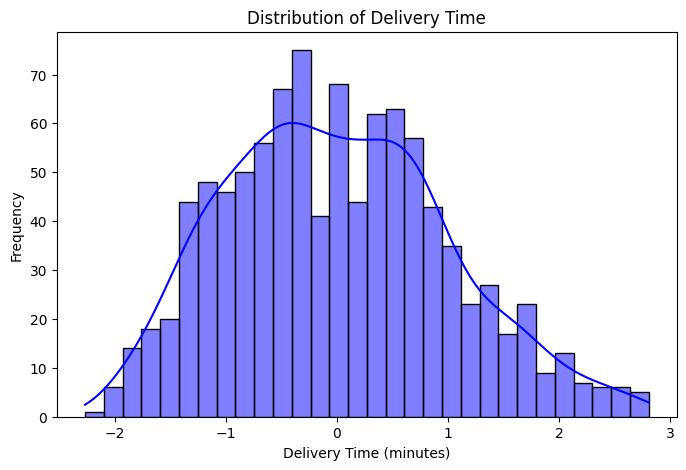

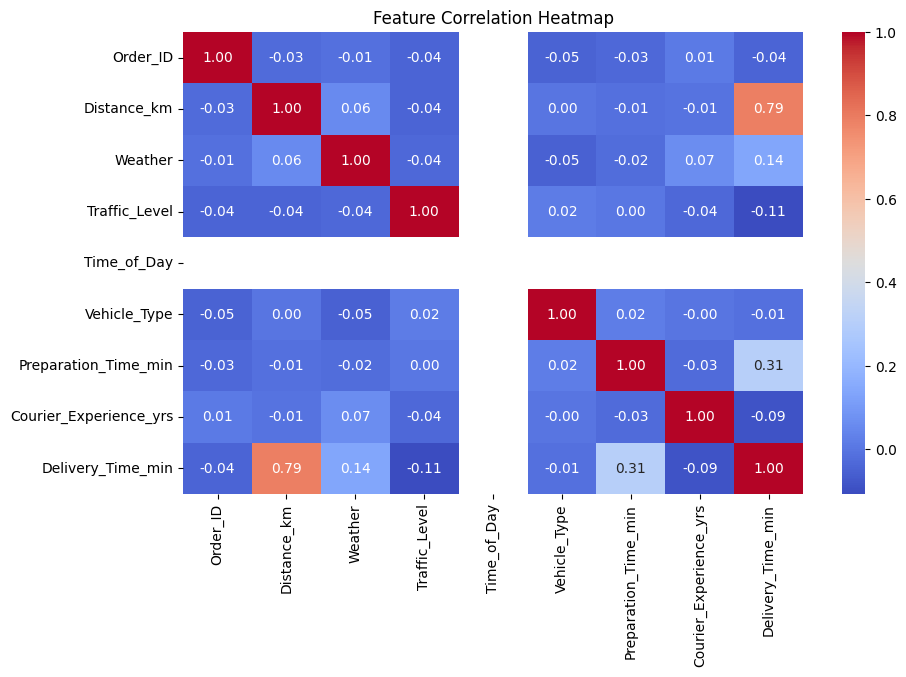

<Figure size 1000x500 with 0 Axes>

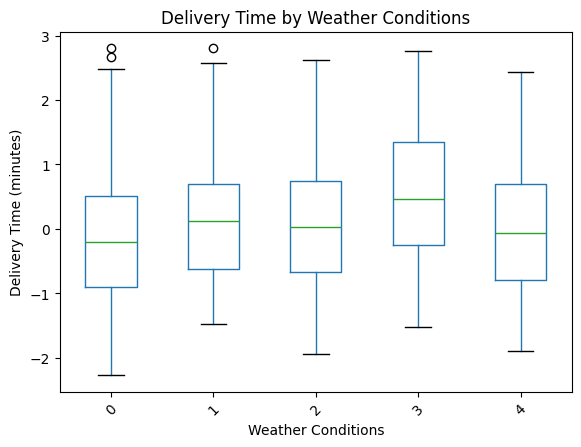

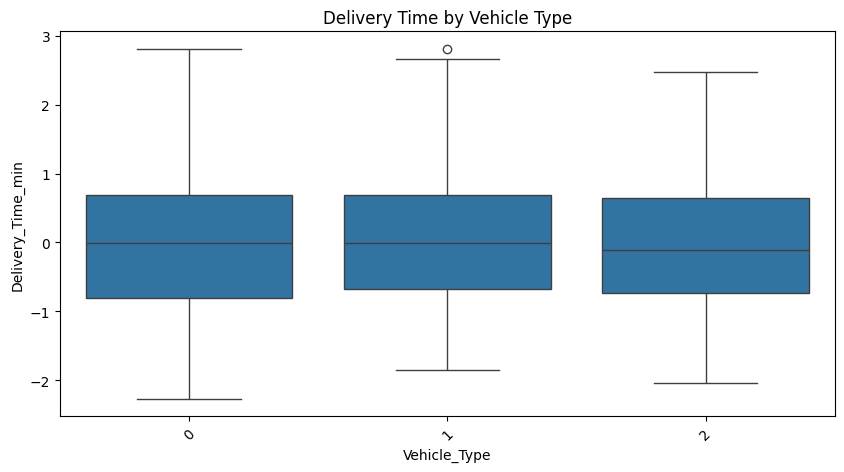

In [7]:
# Data Visualizations
# Import pandas
import pandas as pd

# Load cleaned dataset
df = pd.read_csv("cleaned_food_delivery_times.csv")

# Distribution of target variable (Delivery Time)
plt.figure(figsize=(8, 5))
sns.histplot(df["Delivery_Time_min"], bins=30, kde=True, color="blue")
plt.title("Distribution of Delivery Time")
plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Frequency")
plt.show()

# Correlation heatmap
numerical_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 6))
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()
# Boxplot for Delivery Time by Weather
plt.figure(figsize=(10, 5))
df.boxplot(column="Delivery_Time_min", by="Weather", grid=False)
plt.title("Delivery Time by Weather Conditions")
plt.suptitle("")
plt.xlabel("Weather Conditions")
plt.ylabel("Delivery Time (minutes)")
plt.xticks(rotation=45)
plt.show()

# Boxplot for Delivery Time by Vehicle Type
plt.figure(figsize=(10, 5))
sns.boxplot(x="Vehicle_Type", y="Delivery_Time_min", data=df)
plt.xticks(rotation=45)
plt.title("Delivery Time by Vehicle Type")
plt.show()

In [8]:
# Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Split data into features and target
X = df.drop(columns=["Delivery_Time_min"])  # Features
y = df["Delivery_Time_min"]  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values using imputation
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Now proceed with standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [9]:
# Linear Regression from Scratch (using Normal Equation)
class LinearRegressionScratch:
    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Add intercept
        # Using pseudo-inverse to handle multicollinearity
        self.theta = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    def predict(self, X): # Fixed: Removed extra indent here
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.theta)
# Train and evaluate
lr_scratch = LinearRegressionScratch()
lr_scratch.fit(X_train, y_train)
y_pred_lr_scratch = lr_scratch.predict(X_test)

print("Linear Regression from Scratch Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_lr_scratch))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr_scratch)))
print("R² Score:", r2_score(y_test, y_pred_lr_scratch))


Linear Regression from Scratch Performance:
MAE: 0.3064683028808667
RMSE: 0.45026507095562845
R² Score: 0.8149571140673582


In [10]:
from sklearn.linear_model import Ridge

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Random Forest Regressor ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R² Score:", r2_score(y_test, y_pred_rf))

# --- Ridge Regression ---
ridge = Ridge(alpha=1.0)  # Regularization strength
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("\nRidge Regression Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("R² Score:", r2_score(y_test, y_pred_ridge))

Random Forest Performance:
MAE: 0.3092797014350579
RMSE: 0.45515772145273825
R² Score: 0.8109138557085119

Ridge Regression Performance:
MAE: 0.3067366129856284
RMSE: 0.4503879928600868
R² Score: 0.8148560672386962


In [13]:
# Feature selection and Hyperparameter tuning
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Feature Selection for Random Forest ---
k_rf = 10  # Adjust based on dataset size
selector_rf = SelectKBest(score_func=f_regression, k=k_rf)
X_train_rf_selected = selector_rf.fit_transform(X_train_scaled, y_train)
X_test_rf_selected = selector_rf.transform(X_test_scaled)

selected_rf_features = [X.columns[i] for i in selector_rf.get_support(indices=True)]
print("\nSelected Features for Random Forest:", selected_rf_features)

# --- Feature Selection for Ridge Regression ---
k_ridge = 8  # Adjust based on dataset size
selector_ridge = SelectKBest(score_func=f_regression, k=k_ridge)
X_train_ridge_selected = selector_ridge.fit_transform(X_train_scaled, y_train)
X_test_ridge_selected = selector_ridge.transform(X_test_scaled)

selected_ridge_features = [X.columns[i] for i in selector_ridge.get_support(indices=True)]
print("\nSelected Features for Ridge Regression:", selected_ridge_features)


# Random Forest Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

rf_param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=10,
    scoring="neg_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(X_train, y_train)
best_rf = rf_random_search.best_estimator_

print("\nBest Hyperparameters for Random Forest:", rf_random_search.best_params_)

# Evaluate Random Forest
y_pred_best_rf = best_rf.predict(X_test_rf_selected)
print("\nOptimized Random Forest Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_best_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best_rf)))
print("R² Score:", r2_score(y_test, y_pred_best_rf))

#Ridge Regression Hyperparameter Tuning
ridge_param_grid = {
    "alpha": np.logspace(-4, 4, 50)  # Regularization strength
}

ridge_random_search = RandomizedSearchCV(
    Ridge(),
    param_distributions=ridge_param_grid,
    n_iter=10,
    scoring="neg_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1
)

ridge_random_search.fit(X_train, y_train)
best_ridge = ridge_random_search.best_estimator_

print("\nBest Hyperparameters for Ridge Regression:", ridge_random_search.best_params_)

# Evaluate Ridge Regression
y_pred_best_ridge = best_ridge.predict(X_test_ridge_selected)
print("\nOptimized Ridge Regression Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_best_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best_ridge)))
print("R² Score:", r2_score(y_test, y_pred_best_ridge))




/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=8. All the features will be returned.
  warnings.warn(



Selected Features for Random Forest: ['Order_ID', 'Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs']

Selected Features for Ridge Regression: ['Order_ID', 'Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs']

Best Hyperparameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}

Optimized Random Forest Performance:
MAE: 0.2985562255639974
RMSE: 0.44458288791174694
R² Score: 0.8195979941689961

Best Hyperparameters for Ridge Regression: {'alpha': 1.7575106248547894}

Optimized Ridge Regression Performance:
MAE: 0.3069424103086111
RMSE: 0.4504828767175127
R² Score: 0.8147780499680412


In [15]:
# Comparison
# Calculate R² scores for Random Forest and Ridge Regression
rf_r2 = r2_score(y_test, y_pred_best_rf)  # Calculate R² for Random Forest
ridge_r2 = r2_score(y_test, y_pred_best_ridge)  # Calculate R² for Ridge Regression

# Calculate MAE and RMSE for Random Forest and Ridge Regression
rf_mae = mean_absolute_error(y_test, y_pred_best_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
ridge_mae = mean_absolute_error(y_test, y_pred_best_ridge)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_ridge))

print("\nModel Comparison:")
print("Random Forest:")
print("  MAE:", rf_mae)
print("  RMSE:", rf_rmse)
print("  R² Score:", rf_r2)

print("\nRidge Regression:")
print("  MAE:", ridge_mae)
print("  RMSE:", ridge_rmse)
print("  R² Score:", ridge_r2)

if rf_r2 > ridge_r2:
    best_model = "Random Forest"
    best_model_performance = {"MAE": rf_mae, "RMSE": rf_rmse, "R²": rf_r2}
    best_model_best_features = X_train_rf_selected
    best_model_best_model = best_rf
    X_test_new = X_test_rf_selected
else:
    best_model = "Ridge Regression"
    best_model_performance = {"MAE": ridge_mae, "RMSE": ridge_rmse, "R²": ridge_r2}
    best_model_best_features = X_train_ridge_selected
    best_model_best_model = best_ridge
    X_test_new = X_test_ridge_selected

print(f"\nBest Model: {best_model}")
print("Best Model Performance:")
print(best_model_performance)

# --- Rebuild the Best Model Using Best Hyperparameters and Features ---
# Train the best model on the selected features
best_model_best_model.fit(best_model_best_features, y_train)

# Predict on test set with the best model
y_pred_best_model = best_model_best_model.predict(X_test_new)

# Rebuild Model Performance
print("\nRebuilt Best Model Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_best_model))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best_model)))
print("R² Score:", r2_score(y_test, y_pred_best_model))


Model Comparison:
Random Forest:
  MAE: 0.2985562255639974
  RMSE: 0.44458288791174694
  R² Score: 0.8195979941689961

Ridge Regression:
  MAE: 0.3069424103086111
  RMSE: 0.4504828767175127
  R² Score: 0.8147780499680412

Best Model: Random Forest
Best Model Performance:
{'MAE': 0.2985562255639974, 'RMSE': 0.44458288791174694, 'R²': 0.8195979941689961}

Rebuilt Best Model Performance:
MAE: 0.2985562255639974
RMSE: 0.44458288791174694
R² Score: 0.8195979941689961
